In [137]:
import json
import numpy as np
import matplotlib.pyplot as plt
# import snsphd
import math
import orjson
# Colors, pallet = snsphd.viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6)

In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
def numpyify(data):
    new_dict = {}
    for key in data.keys():
        if type(data[key]) is list:
            new_dict[key] = np.array(data[key])
        else:
            new_dict[key] = data[key]
    
    return new_dict

# 20 GHz

In [5]:
data_list = []
dB_list = [16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]
for dB in dB_list:
    file = f".//20GHz//decode_20GHz{str(dB)}.0.json"

    with open(file, 'r') as file:
        data = json.load(file)
        data_list.append(data[0])

        
# data_list[3]
results = []
for data in data_list:
    A = 0
    B = 0
    C = 0
    D = 0
    for symbol in data:
        if symbol[-1] == 'A':
            A += 1
        if symbol[-1] == 'B':
            B += 1
        if symbol[-1] == 'C':
            C += 1
        if symbol[-1] == 'D':
            D += 1
    dic = {'correct': A, "Berror": B, "Cerror": C, "vacuum": D, "total": A + B + C + D}
    results.append(dic)

In [6]:
correct = np.array([item["correct"]/item["total"] for item in results])
Berror = np.array([item["Berror"]/item["total"] for item in results])
Cerror = np.array([item["Cerror"]/item["total"] for item in results])
Vacuum = np.array([item["vacuum"]/item["total"] for item in results])
MeanPhoton = np.array([-math.log(V) for V in Vacuum])
MeanPhoton

array([6.26395833, 6.45845023, 6.90005907, 5.09017438, 3.4844914 ,
       2.26328687, 1.39788902, 0.91305069, 0.58526076, 0.35080908,
       0.2270399 , 0.15053929, 0.09403525, 0.05721765, 0.03739179,
       0.02183221, 0.01590289])

In [7]:
dB_list
powers = [10**(-db/10) for db in dB_list]
fact = MeanPhoton[-1]/powers[-1]
dbb_MeanPhoton = np.array([a*fact for a in powers])


In [8]:
MeanPhoton

array([6.26395833, 6.45845023, 6.90005907, 5.09017438, 3.4844914 ,
       2.26328687, 1.39788902, 0.91305069, 0.58526076, 0.35080908,
       0.2270399 , 0.15053929, 0.09403525, 0.05721765, 0.03739179,
       0.02183221, 0.01590289])

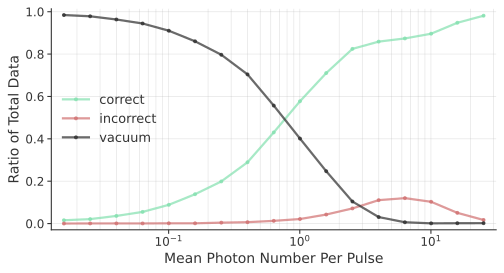

In [9]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
sGreen = "#82e0ae"
sRed = "#d16f6f"
ax.plot(dbb_MeanPhoton, correct, 'o-', label = 'correct', color = sGreen, alpha = 0.7, markersize=3)
ax.plot(dbb_MeanPhoton, Berror + Cerror, 'o-', label='incorrect', color = sRed, alpha = 0.7, markersize=3)
ax.plot(dbb_MeanPhoton, Vacuum, 'o-', label = 'vacuum', color="#2b2b2b", alpha = 0.7, markersize=3)
ax.set_xscale('log')
ax.set_xlabel("Mean Photon Number Per Pulse")
ax.set_ylabel("Ratio of Total Data")
# ax.set_yscale('log')
ax.grid(which='minor')
ax.legend(frameon=False, loc = 'center left')
fig.savefig("Mean Photon with Data Fidelity.svg")

In [11]:
hist_list = []
dB_list = [16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]
for dB in dB_list:
    file = f".//20GHz//decode_20GHz_histGraphs_{str(dB)}.json"

    with open(file, 'r') as file:
        data = json.load(file)
        hist_list.append(numpyify(data))

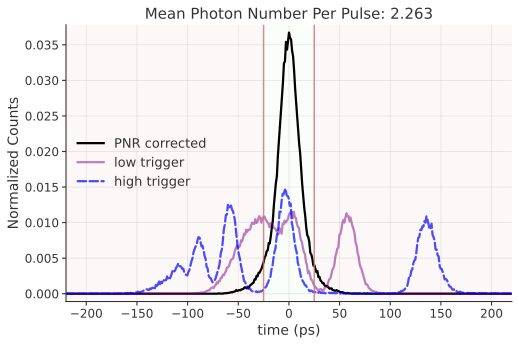

In [27]:
dB_idx = 5
range_left = -220
range_right = 220

hist_list[dB_idx]['corrected_hist1'] = hist_list[dB_idx]['corrected_hist1']/np.sum(hist_list[dB_idx]['corrected_hist1'])
hist_list[dB_idx]['corrected_hist2'] = hist_list[dB_idx]['corrected_hist2']/np.sum(hist_list[dB_idx]['corrected_hist2'])
hist_list[dB_idx]['uncorrected_hist1'] = hist_list[dB_idx]['uncorrected_hist1']/np.sum(hist_list[dB_idx]['uncorrected_hist1'])
hist_list[dB_idx]['uncorrected_hist2'] = hist_list[dB_idx]['uncorrected_hist2']/np.sum(hist_list[dB_idx]['uncorrected_hist2'])

fig, ax = plt.subplots(1,1, figsize = (8,5))


mu_hist1 = np.sum(hist_list[dB_idx]['uncorrected_bins'][:-1]*hist_list[dB_idx]['uncorrected_hist1'])
mu_hist2 = np.sum(hist_list[dB_idx]['uncorrected_bins'][:-1]*hist_list[dB_idx]['uncorrected_hist2'])
mc_hist1 = np.sum(hist_list[dB_idx]['corrected_bins'][:-1]*hist_list[dB_idx]['corrected_hist1'])

ax.plot(hist_list[dB_idx]['corrected_bins'][:-1]-mc_hist1, hist_list[dB_idx]['corrected_hist1'], color = 'k', label="PNR corrected")
ax.plot(hist_list[dB_idx]['uncorrected_bins'][:-1]-mu_hist1, hist_list[dB_idx]['uncorrected_hist1'],color='purple',alpha=0.5, label="low trigger")
ax.plot(hist_list[dB_idx]['uncorrected_bins'][:-1]-mu_hist2, hist_list[dB_idx]['uncorrected_hist2'], '--', color='blue',alpha=0.7, label="high trigger")
ax.axvline(x=25, color=sRed, alpha=0.8, lw = 1.5)
ax.axvline(x=-25, color=sRed, alpha=0.8, lw = 1.5)
ax.set_xlim(range_left,range_right)
ax.legend(loc="center left",frameon=False)
# ax.set_yscale('log')
ax.axvspan(-25,25, color=sGreen, alpha=0.05)
ax.axvspan(range_left,-25, color=sRed, alpha=0.05)
ax.axvspan(25,range_right, color=sRed, alpha=0.05)
ax.set_title(f"Mean Photon Number Per Pulse: {MeanPhoton[dB_idx].round(3)}")
ax.set_xlabel('time (ps)')
ax.set_ylabel('Normalized Counts')
fig.savefig("uncorrected and corrected 2.2.svg")

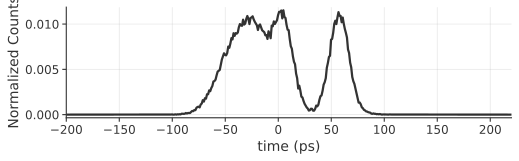

In [28]:
range_left = -200
range_right = 220
fig, ax = plt.subplots(1,1, figsize = (8,2))
ax.plot(hist_list[dB_idx]['uncorrected_bins'][:-1]-mu_hist1, hist_list[dB_idx]['uncorrected_hist1'],color='k',alpha=0.8, label="low trigger")
ax.set_xlim(range_left,range_right)
ax.set_xlabel('time (ps)')
ax.set_ylabel('Normalized Counts')
fig.savefig("low_level_MeanPhoton_2.2.svg")

In [29]:
dB_idx

5

Text(0, 0.5, 'Normalized Counts')

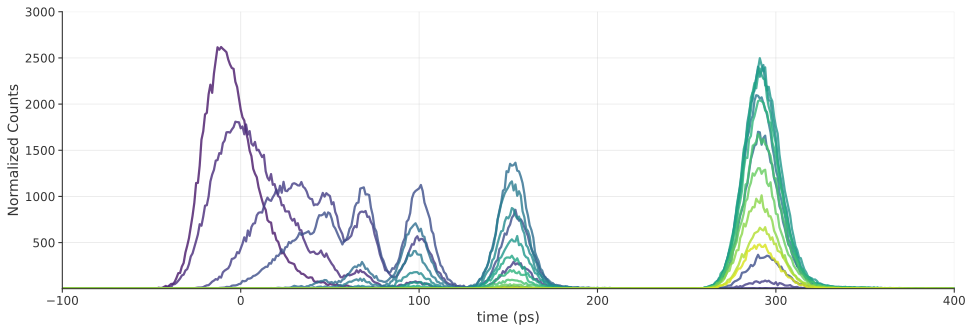

In [136]:
import matplotlib

range_left = -100
range_right = 400
fig, ax = plt.subplots(1,1, figsize = (16,5))
cmap = matplotlib.colormaps['viridis']


# attention!
# these offsets correct for path length delays that occur inside the attentuators
# Each differnt attentaution has a slightly different path length delay
# the values in this 'offsets' list are just guestimates that make the histograms line up with each other
# these offsets should be computationally derived in a rigourous way. For example you could isolate all the |1> photon events, and then find the center of masss for those counts for each attenuation.
    # then use that computed offset instead of the guestimates here. 
offsets = [500, 525, 525, 505, 485, 900, 387, 384, 384, 384, 384, 384, 381, 386, 384, 386, 386]


for dB_ix in range(len(hist_list)):
    # if dB_ix < 1:
    #     mu_hist2 = -600
    

    ax.plot(hist_list[dB_ix]['uncorrected_bins'][:-1]-offsets[dB_ix], hist_list[dB_ix]['uncorrected_hist2'], color=cmap(dB_ix/len(hist_list)),alpha=0.8, label="high trigger")
# ax.set_yscale('log')
ax.set_xlim(range_left,range_right)
ax.set_ylim(1,3000)
ax.set_xlabel('time (ps)')
ax.set_ylabel('Normalized Counts')
    # fig.savefig("high_level_MeanPhoton_2.2.svg")

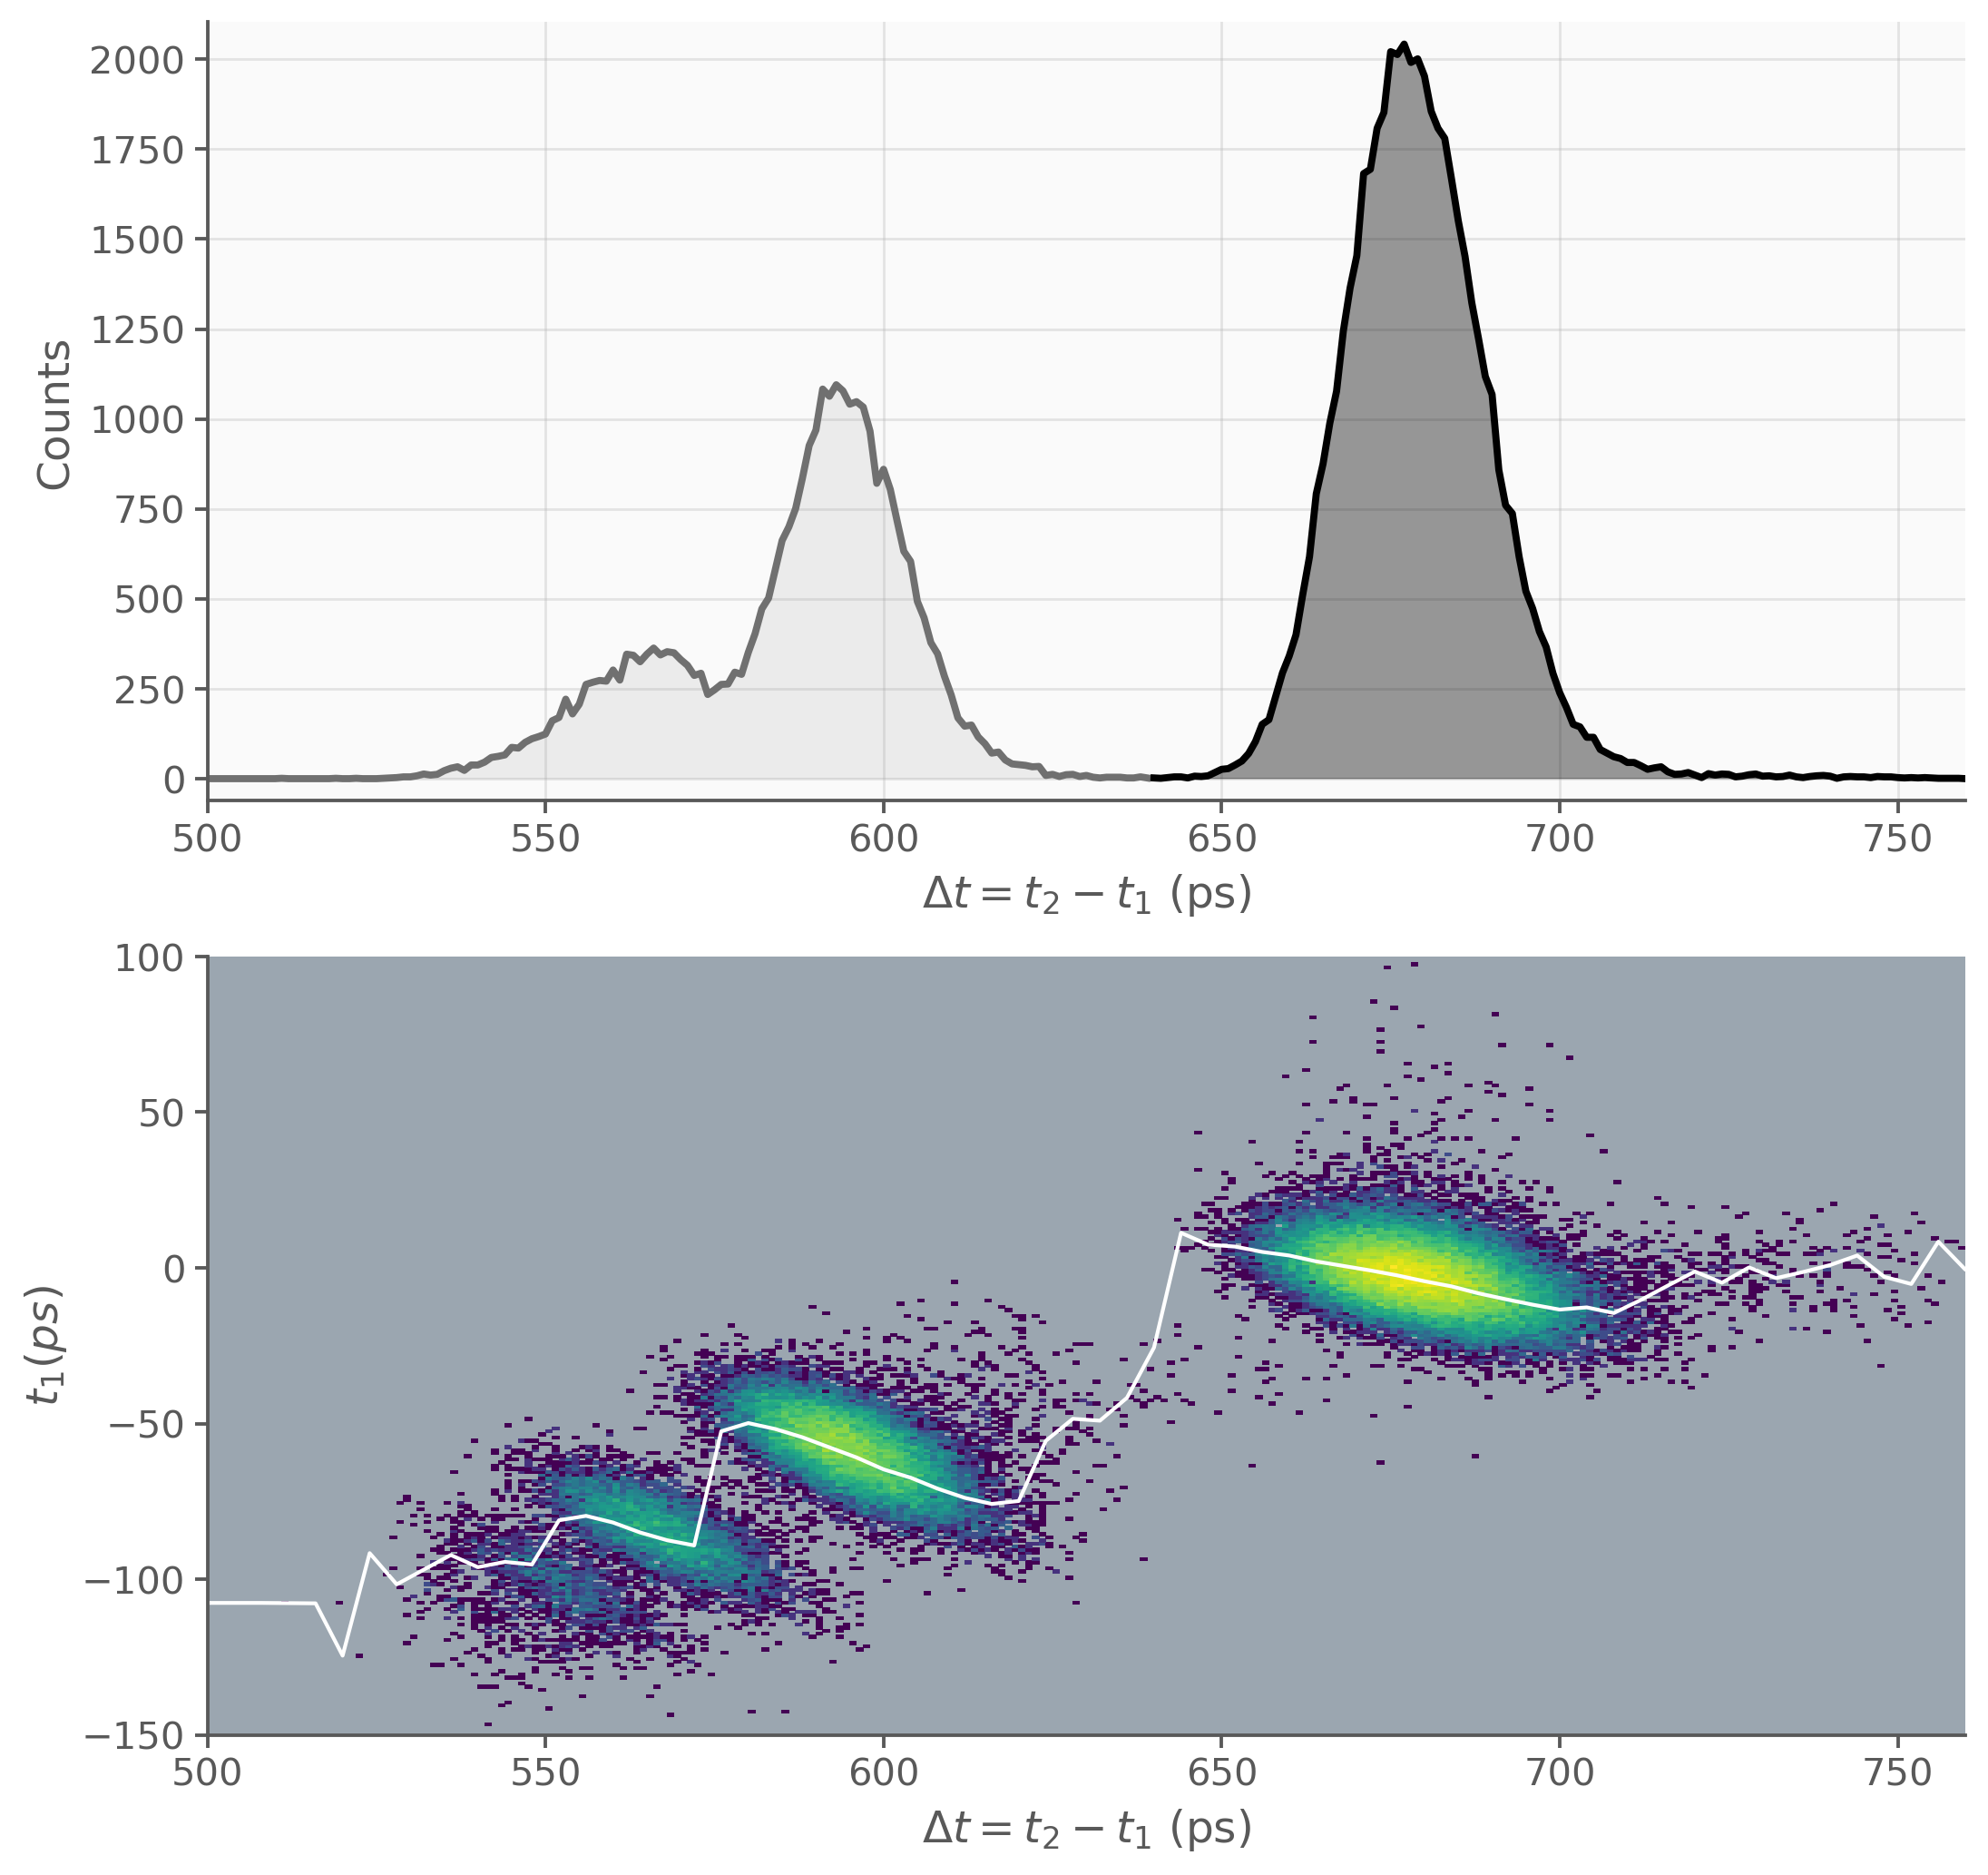

In [75]:
import matplotlib
Colors, pallet = phd.viz.phd_style(jupyterStyle = True, grid = True, axese_width=.5, text = 6)
# %config InlineBackend.figure_formats = ['png']
# plt.rcParams["figure.figsize"] = (20,20)
# plt.rcParams['figure.dpi'] = 70

with open(".//20GHz//PNR_hist_correction_data.json", 'rb') as file:
    data = file.read()

data = numpyify(json.loads(data))
bins = np.arange(-1000,1000)

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[1].set_facecolor('#9ba6b0')
ax[1].hist2d(data['counts'][:, 1] - data['counts'][:, 0], data['counts'][:, 0], bins=(bins, bins),norm=matplotlib.colors.LogNorm())
ax[1].plot(data['slices'][:-1], data['corr1'], color='w', lw='1.2')
ax[1].set_ylim(-150,100)
ax[1].set_xlim(500,760)
ax[1].set_xlabel(r"$\Delta t = t_2 - t_1$ (ps)")
ax[1].set_ylabel(r"$t_1 (ps)$")


hist_data, bins = np.histogram(data['counts'][:, 1] - data['counts'][:, 0], bins=bins)
ax[0].plot(bins[:-1][:1640], hist_data[:1640], color="#707070")
ax[0].plot(bins[:-1][1640:], hist_data[1640:], color="k")

ax[0].fill_between(bins[:-1][:1640],0,hist_data[:1640], alpha = 0.1, color='#707070')
ax[0].fill_between(bins[:-1][1640:], hist_data[1640:], alpha = 0.4, color='k')

ax[0].set_xlim(500,760)
ax[0].set_xlabel(r"$\Delta t = t_2 - t_1$ (ps)")
ax[0].set_ylabel("Counts")
fig.savefig("hist and calibration line.png")

In [52]:
len(hist_data)

1999

### I need to define mean photon number per data pulse and use that on the y axis

In [65]:
from imageEncoder import list_to_image, image_to_list, add_errors
import yaml
import numpy as np
from PIL import Image
import yaml
from bitstring import BitArray, BitStream
import math

In [66]:
def list_to_image_local(ls,params, save_name = False):
    length = int(math.log2(params["ppm"]["m_value"]))
    cbin = ''
    decoding_info = '#0' + str(length + 2) + 'b'
    for i, number in enumerate(ls):
#         if i < 0:
#             continue
#         if i >= len(ls) - 9:
#             continue
        if number < 0:
            number = 0
        cbin = cbin + format(number, decoding_info)[2:]
    cbin = '0b' + cbin
    #print("decoded cbin beginning: ", cbin[:40])
    #print("decoded cbin ending: ", cbin[-40:])
    n = BitStream(cbin)
    arr = []
    while n.pos <= (len(n)//8)*8 - 8:
        arr.append(n.read('uint:8'))
    # print("beginning of decoded array: ", arr[:20])
    # print("end of decoded array: ", arr[-20:])
    arr = np.array(arr)
    arr = arr.reshape((64,64,3))
    img = Image.fromarray(arr.astype('uint8'))
    img = img.resize((64*10,64*10), resample=Image.BOX)
    img.show()
    if save_name:
        img.save(save_name)

## This one generates images and takes a while

In [67]:
params_path = "..\\..\\..\\Sent_Data_Backup\\tempImgSave\\0_21.07.28.10.27_params.yml"
stream = open(params_path, 'r')
params = yaml.load(stream, Loader=yaml.FullLoader)


for j, dB in enumerate(dB_list):
    image_name = "20GHz_" + str(dB) + 'dB.png'
    data = [data_list[j][i][0] for i in range(len(data_list[0]))]
    list_to_image_local(data,params,image_name)
# list_to_image(data,params)
# len(data)/11

In [95]:
data.keys()

dict_keys(['corrected_hist1', 'corrected_hist2', 'corrected_bins', 'uncorrected_bins', 'uncorrected_hist1', 'uncorrected_hist2'])

In [97]:
type(data["uncorrected_bins"])

list

In [103]:
numpyify(data)

yes
yes
yes
yes
yes
yes


{'corrected_hist1': array([0, 0, 0, ..., 0, 0, 0]),
 'corrected_hist2': array([0, 0, 0, ..., 0, 0, 0]),
 'corrected_bins': array([ -83.14453125,  -82.14453125,  -81.14453125, ..., 3527.85546875,
        3528.85546875, 3529.85546875]),
 'uncorrected_bins': array([-5000, -4999, -4998, ...,  4997,  4998,  4999]),
 'uncorrected_hist1': array([0, 0, 0, ..., 0, 0, 0]),
 'uncorrected_hist2': array([0, 0, 0, ..., 0, 0, 0])}